# Style Transfer: An Overview

In simple terms, style transfer is a fascinating technique that blends the content of one image with the style of another, resulting in a unique visual synthesis. Through advanced algorithms and neural networks, it extracts the stylistic elements from one image and applies them to another, creating visually compelling compositions. In this notebook, we'll dive into the world of style transfer, exploring how we can leverage deep learning to infuse our digital creations with artistic flair.


## Imports

In [15]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Loading the VGG model

In [3]:
img_size = 720
VGG_Model = tf.keras.applications.VGG19(
    input_shape=(img_size,img_size,3),
    include_top=False,
    weights='imagenet'
)
VGG_Model.trainable = False

80134624/80134624 [==============================] - 68s 1us/step


# Content Coast function

In [4]:
def compute_content_cost(content_output, generated_output):

    a_C = content_output[-1]
    a_G = generated_output[-1]
    m, n_H, n_W, n_C = a_C.get_shape().as_list()
    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H * n_W, n_C])
    
   
    J_content =  tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))/(4.0 * n_H * n_W * n_C)
    
    return J_content

# Style Cost function

In [5]:
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))
    return GA

In [6]:
def compute_layer_style_cost(a_S, a_G):
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = tf.reduce_sum(tf.square(GS - GG))/(4.0 *(( n_H * n_W * n_C)**2))
    
    
    return J_style_layer

In [7]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [8]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):

    J_style = 0

    a_S = style_image_output[:-1]

    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        J_style += weight[1] * J_style_layer

    return J_style

# Total cost

In [38]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = alpha * J_content + beta * J_style
    return J

# Putting it all together

(1, 720, 720, 3)


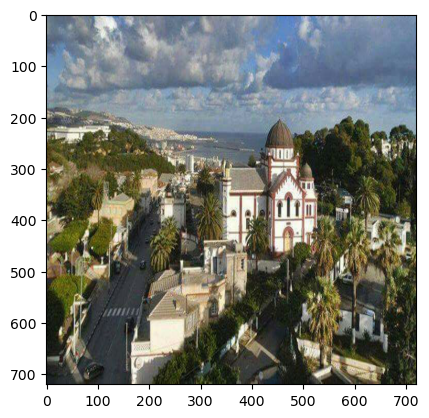

In [23]:
content_image = np.array(Image.open("data/content.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
plt.imshow(content_image[0])
plt.show()

(1, 720, 720, 3)


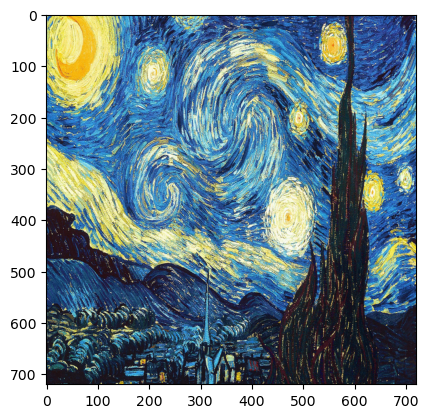

In [24]:
style_image = np.array(Image.open("data/style.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
plt.imshow(style_image[0])
plt.show()

(1, 720, 720, 3)


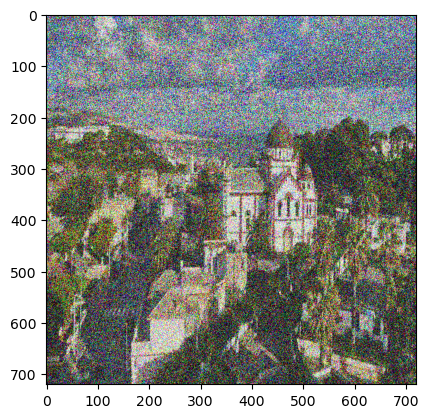

In [27]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.7, 0.7)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
plt.imshow(generated_image.numpy()[0])
plt.show()

In [28]:
def get_layer_outputs(vgg, layer_names):
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [30]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(VGG_Model, STYLE_LAYERS + content_layer)

In [31]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style encoder

In [32]:
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

In [33]:
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [34]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [40]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

def train_step(generated_image):
    with tf.GradientTape() as tape:
        # In this function you must use the precomputed encoded images a_S and a_C
        
        ### START CODE HERE
        
        # Compute a_G as the vgg_model_outputs for the current generated image
        #(1 line)
        a_G = vgg_model_outputs(generated_image)
        
        # Compute the style cost
        #(1 line)
        J_style = compute_style_cost(a_S, a_G)

        #(2 lines)
        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)
        # Compute the total cost
        J = total_cost(J_content, J_style)
        
        ### END CODE HERE
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    # For grading purposes
    return J

Epoch 0
Epoch 0 


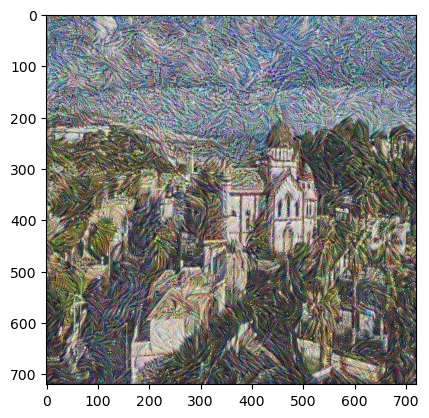

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 5 


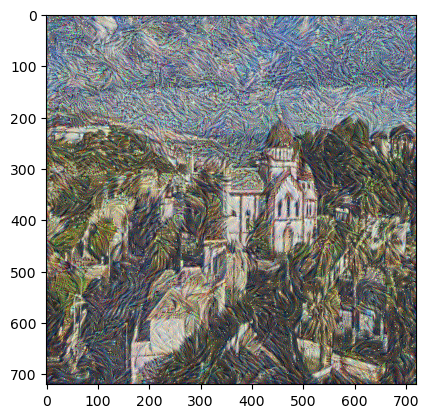

Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 10 


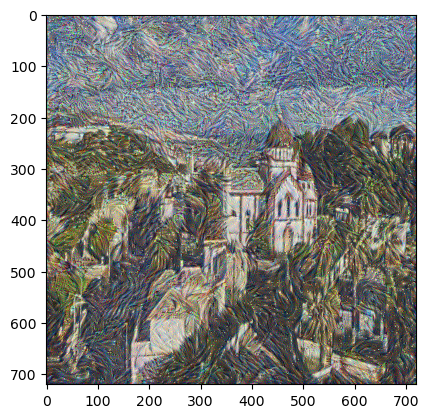

Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 15 


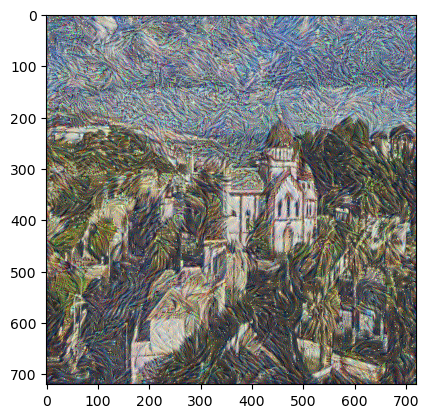

Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 20 


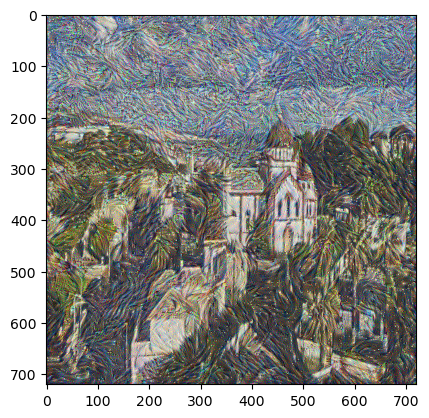

Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 25 


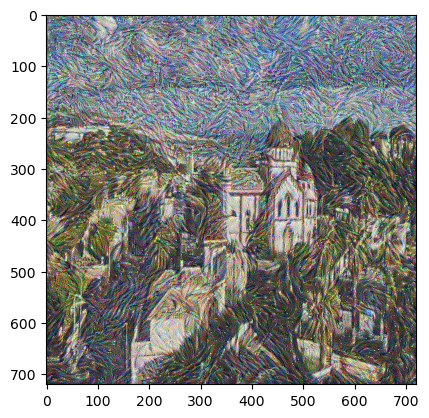

Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 30 


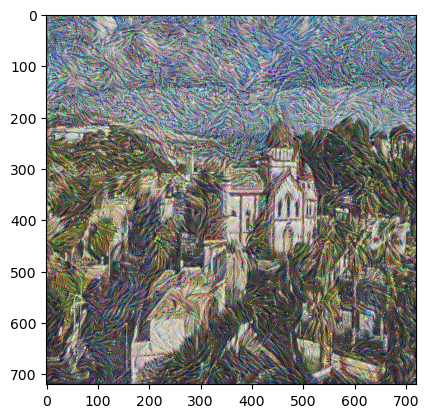

Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 35 


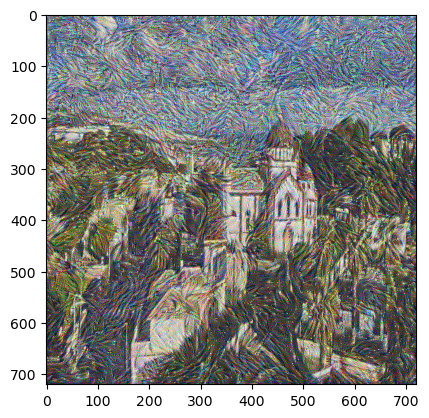

Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 40 


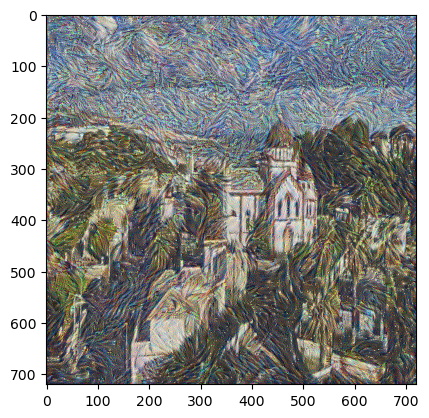

Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 45 


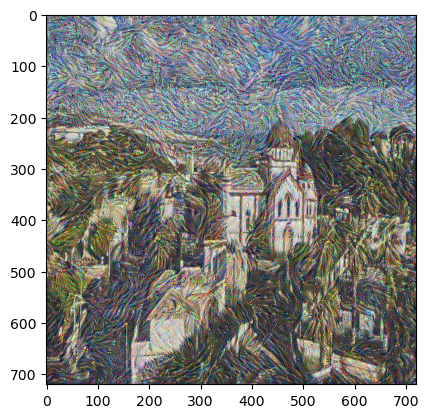

Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 50 


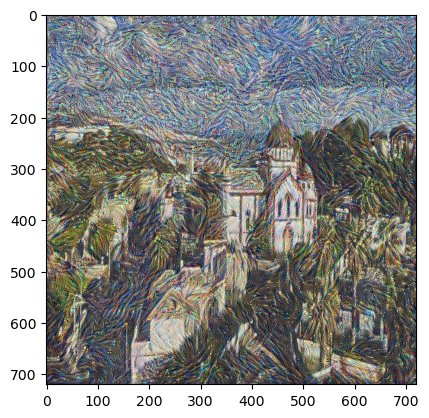

Epoch 51
Epoch 52
Epoch 53


KeyboardInterrupt: 

In [44]:
epochs = 100
for i in range(epochs):
    print(f"Epoch {i}")
    train_step(generated_image)
    if i % 5 == 0:
        print(f"Epoch {i} ")
    if i % 5 == 0:
        image = tensor_to_image(generated_image)
        plt.imshow(image)
        plt.show() 